In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils import shuffle

from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
import tensorflow as tf
from keras import backend as K 

from scipy import interpolate
import math

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [27]:
N = 100000
N2 = int(N/2)

# sr_s1, sr_s2, sb_s1, sb_s2 = 0.1, -0.1, 0.05, 0
sr_s1, sr_s2, sb_s1, sb_s2 = 0, 0, 0, 0
SR_background_data = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)
SB_background_data = np.random.multivariate_normal([1,0],[[1,0],[0,1]],N)
SR_background_sim = np.random.multivariate_normal([sr_s1,sr_s2],[[1,0],[0,1]],N)
SR_background_sim_2 = np.random.multivariate_normal([sr_s1,sr_s2],[[1,0],[0,1]],N)
SB_background_sim = np.random.multivariate_normal([1 + sb_s1,sb_s2],[[1,0],[0,1]],N)

SR_signal = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N)

SR_background_data_fortest = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N*10)
SR_signal_fortest = np.random.multivariate_normal([1.5,1.5],[[0.5,0],[0,0.5]],N*10)

EPOCHS = 100

In [42]:
SR_background_data_2 = np.random.multivariate_normal([0,0],[[1,0],[0,1]],N)

Text(0, 0.5, 'events')

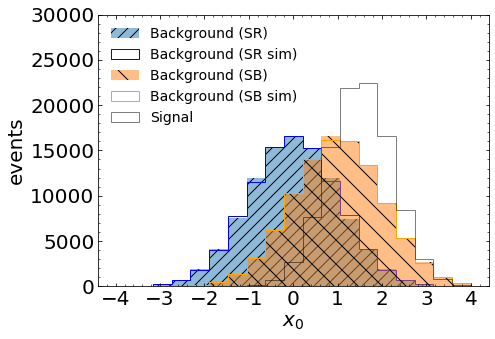

In [3]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SR_background_sim[:, 0], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SR sim)', color='blue')
plt.hist(SB_background_data[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SB_background_sim[:, 0], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SB sim)', color='orange')
plt.hist(SR_signal[:,0],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_0$",fontsize=20)
plt.ylabel("events",fontsize=20)

# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)

Text(0, 0.5, 'events')

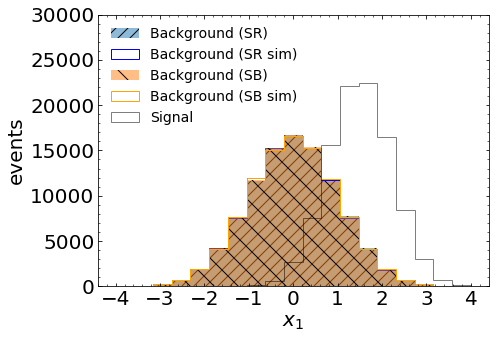

In [4]:
fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.hist(SR_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SR)",hatch='//')
plt.hist(SR_background_sim[:, 1], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SR sim)', color='blue')
plt.hist(SB_background_data[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Background (SB)",hatch='\\')
plt.hist(SB_background_sim[:, 1], bins=np.linspace(-4, 4, 20), histtype='step', 
         label='Background (SB sim)', color='orange')
plt.hist(SR_signal[:,1],bins=np.linspace(-4,4,20),alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper left")
plt.ylim([0,30000])
plt.xlabel("$x_1$",fontsize=20)
plt.ylabel("events",fontsize=20)

# plt.savefig('plots/x1.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x1.pdf', bbox_inches='tight', padinches=0)

In [28]:
#First, let's do fully supervised

X_sup_train = np.concatenate([SR_signal,SR_background_data])
Y_sup_train = np.concatenate([np.ones(len(SR_signal)),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
Y_sup_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])

In [29]:
model_sup = Sequential()
model_sup.add(Dense(64, input_dim=2, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup = model_sup.predict(X_sup_val,batch_size=int(0.1*len(X_sup_val)))
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/100
200000/200000 [==============================] - 2s 8us/step - loss: 0.6298 - acc: 0.7875
Epoch 2/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5212 - acc: 0.8182
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4198 - acc: 0.8502
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.3345 - acc: 0.8789
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2845 - acc: 0.8877
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2649 - acc: 0.8914
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2553 - acc: 0.8944
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2496 - acc: 0.8966
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2470 - acc: 0.8981
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8989
Epoch 81/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8991
Epoch 82/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8991
Epoch 83/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8990
Epoch 84/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8990
Epoch 85/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8991
Epoch 86/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8990
Epoch 87/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8990
Epoch 88/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.2443 - acc: 0.8991
Epoch 89/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.24

In [30]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,1], Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d = model_sup1d.predict(X_sup_val[:,1],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d, tpr_sup1d, _ = roc_curve(Y_sup_val, scores_sup1d)

Epoch 1/100
200000/200000 [==============================] - 2s 9us/step - loss: 0.6744 - acc: 0.6629
Epoch 2/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.6050 - acc: 0.7599
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5395 - acc: 0.7781
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4766 - acc: 0.7937
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4328 - acc: 0.8065
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4124 - acc: 0.8127
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4074 - acc: 0.8145
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4076 - acc: 0.8146
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4073 - acc: 0.8147
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8146
Epoch 81/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8148
Epoch 82/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8148
Epoch 83/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8145
Epoch 84/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8147
Epoch 85/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8147
Epoch 86/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8146
Epoch 87/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4070 - acc: 0.8146
Epoch 88/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8145
Epoch 89/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.40

In [31]:
model_sup1d = Sequential()
model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(64, activation='relu'))
model_sup1d.add(Dense(1, activation='sigmoid'))
model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup1d.fit(X_sup_train[:,0], Y_sup_train, epochs=EPOCHS, batch_size=int(0.1*len(X_sup_train)))

scores_sup1d_x0 = model_sup1d.predict(X_sup_val[:,0],batch_size=int(0.1*len(X_sup_val)))
fpr_sup1d_x0, tpr_sup1d_x0, _ = roc_curve(Y_sup_val, scores_sup1d_x0)

Epoch 1/100
200000/200000 [==============================] - 2s 9us/step - loss: 0.6540 - acc: 0.7110
Epoch 2/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5754 - acc: 0.7667
Epoch 3/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.5095 - acc: 0.7763
Epoch 4/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4587 - acc: 0.7981
Epoch 5/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4239 - acc: 0.8131
Epoch 6/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4091 - acc: 0.8151
Epoch 7/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4071 - acc: 0.8150
Epoch 8/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4071 - acc: 0.8151
Epoch 9/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4069 - acc: 0.8149
Epoch 10/100
200000/200000 [==============================] - 0s 1us/step - loss: 

200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8151
Epoch 81/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8152
Epoch 82/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8152
Epoch 83/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8148
Epoch 84/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8152
Epoch 85/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8153
Epoch 86/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8151
Epoch 87/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8151
Epoch 88/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.4064 - acc: 0.8151
Epoch 89/100
200000/200000 [==============================] - 0s 1us/step - loss: 0.40

In [32]:
Nsig = 500
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2])**0.5)
print(len(SR_signal[0:Nsig])/len(SR_background_data[0:N2]))

2.23606797749979
0.01


In [33]:
n_injections = 10
signals_to_inject = [None] * n_injections
for i in range(n_injections):
    signals_to_inject[i] = SR_signal[np.random.choice(SR_signal.shape[0], size=Nsig, replace=False), :]

In [86]:
#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(10):
    print('Training i = %i' % i)
    signal_to_inject = signals_to_inject[i]
    
    X_dvsim_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SR_background_sim[0:N2]])
    Y_dvsim_train = np.concatenate([np.ones(len(signal_to_inject)),np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SR_background_sim[0:N2]))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    tf.keras.backend.clear_session()
    model_dvsim = Sequential()
    model_dvsim.add(Dense(64, input_dim=2, activation='relu')) 
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(1, activation='sigmoid'))
    model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_dvsim = model_dvsim.fit(X_dvsim_train, Y_dvsim_train, epochs=EPOCHS, 
                                 batch_size=int(0.1*len(X_dvsim_train)))

    scores_dvsim = model_dvsim.predict(X_dvsim_val,batch_size=int(0.1*len(X_dvsim_val)))
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

Training i = 0
Epoch 1/100
100500/100500 [==============================] - 1s 6us/step - loss: 0.6929 - acc: 0.5034
Epoch 2/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5035
Epoch 3/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5035
Epoch 4/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5035
Epoch 5/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5036
Epoch 6/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5036
Epoch 7/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5036
Epoch 8/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5036
Epoch 9/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5038
Epoch 10/100
100500/100500 [==============================] - 0s 1u

100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5045
Epoch 81/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5046
Epoch 82/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5047
Epoch 83/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5043
Epoch 84/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5045
Epoch 85/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5045
Epoch 86/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5045
Epoch 87/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5044
Epoch 88/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5045
Epoch 89/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 60/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 61/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 62/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 63/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 64/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5049
Epoch 65/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 66/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 67/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5051
Epoch 68/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5051
Epoch 39/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 40/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5049
Epoch 41/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 42/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 43/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5049
Epoch 44/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5050
Epoch 45/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5051
Epoch 46/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 47/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 18/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5052
Epoch 19/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 20/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5052
Epoch 21/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5052
Epoch 22/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 23/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 24/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 25/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 26/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 97/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 98/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 99/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 100/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Training i = 4
Epoch 1/100
100500/100500 [==============================] - 1s 6us/step - loss: 0.6927 - acc: 0.5054
Epoch 2/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5056
Epoch 3/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5049
Epoch 4/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5055
Epoch 5/100
100500/100500 [==============================] - 0s 1us/step -

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 76/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 77/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 78/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 79/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 80/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 81/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5051
Epoch 82/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 83/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 84/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 55/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 56/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 57/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 58/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 59/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 60/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 61/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5051
Epoch 62/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 63/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 34/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5054
Epoch 35/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 36/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 37/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 38/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 39/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5058
Epoch 40/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5053
Epoch 41/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5029
Epoch 42/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 13/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 14/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 15/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5058
Epoch 16/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5059
Epoch 17/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 18/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 19/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5058
Epoch 20/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5055
Epoch 21/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5059
Epoch 92/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5056
Epoch 93/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5052
Epoch 94/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5059
Epoch 95/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5056
Epoch 96/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 97/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5056
Epoch 98/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5057
Epoch 99/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5055
Epoch 100/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6

100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5057
Epoch 71/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5060
Epoch 72/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5035
Epoch 73/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5033
Epoch 74/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5056
Epoch 75/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5059
Epoch 76/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5058
Epoch 77/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5058
Epoch 78/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5057
Epoch 79/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 50/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6926 - acc: 0.5057
Epoch 51/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5058
Epoch 52/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5058
Epoch 53/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5056
Epoch 54/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5059
Epoch 55/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5057
Epoch 56/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5059
Epoch 57/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.6925 - acc: 0.5057
Epoch 58/100
100500/100500 [==============================] - 0s 1us/step - loss: 0.69

In [87]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(10):
    print('Training i = %i' % i)
    signal_to_inject = signals_to_inject[i]
    
    X_ocwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SR_background_data[N2:-1]])
    Y_ocwola_train = np.concatenate([np.ones(len(signal_to_inject)),np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SR_background_data[N2:-1]))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    X_ocwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    tf.keras.backend.clear_session()
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ocwola = model_ocwola.fit(X_ocwola_train, Y_ocwola_train, epochs=EPOCHS, 
                                 batch_size=int(0.1*len(X_ocwola_train)))

    scores_ocwola = model_ocwola.predict(X_ocwola_val,batch_size=int(0.1*len(X_ocwola_val)))
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

Training i = 0
Epoch 1/100
100499/100499 [==============================] - 1s 6us/step - loss: 0.6933 - acc: 0.5054
Epoch 2/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6934 - acc: 0.5029
Epoch 3/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5030
Epoch 4/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5039
Epoch 5/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5050
Epoch 6/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6933 - acc: 0.5029
Epoch 7/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5027
Epoch 8/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5052
Epoch 9/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6932 - acc: 0.5036
Epoch 10/100
100499/100499 [==============================] - 0s 1u

100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5029
Epoch 81/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5050
Epoch 82/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5051
Epoch 83/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5048
Epoch 84/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5046
Epoch 85/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5039
Epoch 86/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5027
Epoch 87/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5034
Epoch 88/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5046
Epoch 89/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5027
Epoch 60/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5032
Epoch 61/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5028
Epoch 62/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5031
Epoch 63/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5029
Epoch 64/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5027
Epoch 65/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5029
Epoch 66/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5053
Epoch 67/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5060
Epoch 68/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5058
Epoch 39/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5058
Epoch 40/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5058
Epoch 41/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5056
Epoch 42/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5058
Epoch 43/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6931 - acc: 0.5055
Epoch 44/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6931 - acc: 0.5048
Epoch 45/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6931 - acc: 0.5053
Epoch 46/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5055
Epoch 47/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5026
Epoch 18/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5026
Epoch 19/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 20/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 21/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 22/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 23/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 24/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 25/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 26/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5027
Epoch 97/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5026
Epoch 98/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5026
Epoch 99/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5025
Epoch 100/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5026
Training i = 4
Epoch 1/100
100499/100499 [==============================] - 1s 6us/step - loss: 0.6927 - acc: 0.5026
Epoch 2/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5026
Epoch 3/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6927 - acc: 0.5055
Epoch 4/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5054
Epoch 5/100
100499/100499 [==============================] - 0s 1us/step -

100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 76/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 77/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 78/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 79/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 80/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 81/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 82/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 83/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 84/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5044
Epoch 55/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5042
Epoch 56/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5045
Epoch 57/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5043
Epoch 58/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5043
Epoch 59/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5041
Epoch 60/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5041
Epoch 61/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5039
Epoch 62/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5038
Epoch 63/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5024
Epoch 34/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5023
Epoch 35/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 36/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 37/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5026
Epoch 38/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 39/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5018
Epoch 40/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5021
Epoch 41/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5023
Epoch 42/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5031
Epoch 13/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5034
Epoch 14/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5037
Epoch 15/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5040
Epoch 16/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5044
Epoch 17/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5039
Epoch 18/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5039
Epoch 19/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5037
Epoch 20/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5039
Epoch 21/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5039
Epoch 92/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5041
Epoch 93/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5042
Epoch 94/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5041
Epoch 95/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5040
Epoch 96/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5041
Epoch 97/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5040
Epoch 98/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5043
Epoch 99/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5013
Epoch 100/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6

100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 71/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 72/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 73/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 74/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5025
Epoch 75/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5020
Epoch 76/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5020
Epoch 77/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5018
Epoch 78/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5017
Epoch 79/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

100499/100499 [==============================] - 0s 1us/step - loss: 0.6928 - acc: 0.5034
Epoch 50/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5028
Epoch 51/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 52/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 53/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 54/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6930 - acc: 0.5025
Epoch 55/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 56/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 57/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6929 - acc: 0.5025
Epoch 58/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.69

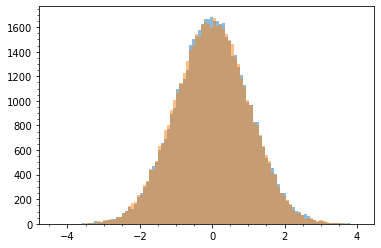

In [85]:
_, b, _ = plt.hist(SR_background_data[0:N2,0], bins=100, alpha=0.5)
plt.hist(SR_background_sim[0:N2, 0], bins=b, alpha=0.5)
plt.minorticks_on()

In [88]:
# data v sim
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(dvsim_rocs)

for i, row in dvsim_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

dvsim_max = np.nanmax(fpr_interp, axis=0)
dvsim_min = np.nanmin(fpr_interp, axis=0)
dvsim_med = np.median(fpr_interp, axis=0)
dvsim_std = np.std(fpr_interp, axis=0)

# optimal CWoLa
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(ocwola_rocs)

for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

ocwola_max = np.nanmax(fpr_interp, axis=0)
ocwola_min = np.nanmin(fpr_interp, axis=0)
ocwola_med = np.median(fpr_interp, axis=0)
ocwola_std = np.std(fpr_interp, axis=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, '10 classifiers')

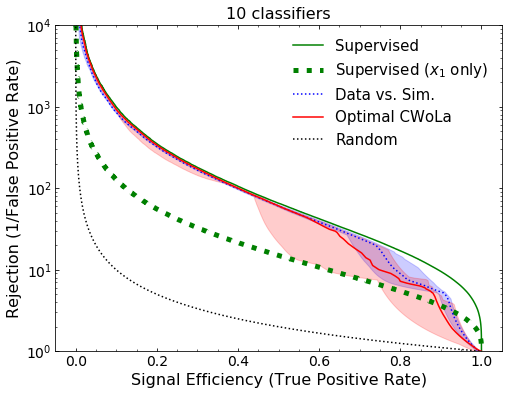

In [89]:
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med,label="Data vs. Sim.",color="blue",ls=":")
plt.fill_between(tpr_pts, dvsim_max, dvsim_min, color='blue', alpha=0.2)

plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.fill_between(tpr_pts, ocwola_max, ocwola_min, color='red', alpha=0.2)

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('10 classifiers', fontsize=16)

# plt.savefig('plots/toy_dvsim_ocwola_single_signal_clear_session.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/toy_dvsim_ocwola_single_signal_clear_session.pdf', bbox_inches='tight', padinches=0)

In [18]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]
    
    X_cwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2], SB_background_data[N2:-1]])
    Y_cwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                    np.zeros(len(SB_background_data[N2:-1]))])

    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

    X_cwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train, Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=int(0.1*len(X_cwola_train)))

    scores_cwola = model_cwola.predict(X_cwola_val,batch_size=int(0.1*len(X_cwola_val)))
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

Training i = 0
Epoch 1/100
100499/100499 [==============================] - 1s 9us/step - loss: 0.6737 - acc: 0.5862
Epoch 2/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.6190 - acc: 0.6771
Epoch 3/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5941 - acc: 0.6834
Epoch 4/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5917 - acc: 0.6822
Epoch 5/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5907 - acc: 0.6841
Epoch 6/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5876 - acc: 0.6870
Epoch 7/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5877 - acc: 0.6868
Epoch 8/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5880 - acc: 0.6836
Epoch 9/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6874
Epoch 10/100
100499/100499 [==============================] - 0s 1u

100499/100499 [==============================] - 0s 1us/step - loss: 0.5871 - acc: 0.6870
Epoch 60/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5866 - acc: 0.6872
Epoch 61/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5865 - acc: 0.6875
Epoch 62/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5872 - acc: 0.6868
Epoch 63/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5871 - acc: 0.6871
Epoch 64/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5862 - acc: 0.6873
Epoch 65/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6870
Epoch 66/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5872 - acc: 0.6855
Epoch 67/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5886 - acc: 0.6859
Epoch 68/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.58

100499/100499 [==============================] - 0s 1us/step - loss: 0.5856 - acc: 0.6875
Epoch 18/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5869 - acc: 0.6865
Epoch 19/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6864
Epoch 20/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5874 - acc: 0.6863
Epoch 21/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6869
Epoch 22/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5869 - acc: 0.6877
Epoch 23/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5873 - acc: 0.6866
Epoch 24/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5875 - acc: 0.6873
Epoch 25/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5865 - acc: 0.6873
Epoch 26/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.58

100499/100499 [==============================] - 0s 1us/step - loss: 0.5878 - acc: 0.6868
Epoch 76/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5870 - acc: 0.6875
Epoch 77/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5856 - acc: 0.6878
Epoch 78/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5860 - acc: 0.6875
Epoch 79/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5857 - acc: 0.6881
Epoch 80/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5860 - acc: 0.6874
Epoch 81/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5868 - acc: 0.6868
Epoch 82/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5860 - acc: 0.6875
Epoch 83/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.5861 - acc: 0.6875
Epoch 84/100
100499/100499 [==============================] - 0s 1us/step - loss: 0.58

In [19]:
#Next is SA-CWoLa

mylambda = 2.

sacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in range(5):
    print('Training i = %i' % i)
    
    signal_to_inject = signals_to_inject[i]

    X_sacwola_train = np.concatenate([signal_to_inject, SR_background_data[0:N2],SB_background_data[N2:-1],
                                      SR_background_sim[0:N2],SB_background_sim[N2:-1]])
    Y_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.zeros(len(SB_background_data[N2:-1])),
                                      np.ones(len(SR_background_sim[0:N2])),
                                      np.zeros(len(SB_background_sim[N2:-1]))])
    W_sacwola_train = np.concatenate([np.ones(len(signal_to_inject)), np.ones(len(SR_background_data[0:N2])),
                                      np.ones(len(SB_background_data[N2:-1])),
                                      -mylambda*np.ones(len(SR_background_sim[0:N2])),
                                      -mylambda*np.ones(len(SB_background_sim[N2:-1]))])

    X_sacwola_train, Y_sacwola_train, W_sacwola_train = shuffle(X_sacwola_train, Y_sacwola_train,W_sacwola_train)

    X_sacwola_val = np.concatenate([SR_signal_fortest,SR_background_data_fortest])
    Y_sacwola_val = np.concatenate([np.ones(len(SR_signal_fortest)),np.zeros(len(SR_background_data_fortest))])
    
    model_sacwola = Sequential()
    model_sacwola.add(Dense(64, input_dim=2, activation='relu')) 
    model_sacwola.add(Dense(64, activation='relu'))
    model_sacwola.add(Dense(64, activation='relu'))
    model_sacwola.add(Dense(1, activation='sigmoid'))
    model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sacwola = model_sacwola.fit(X_sacwola_train, Y_sacwola_train, epochs=EPOCHS, 
                                     batch_size=int(0.1*len(X_sacwola_train)),sample_weight=W_sacwola_train)

    scores_sacwola = model_sacwola.predict(X_sacwola_val,batch_size=int(0.1*len(X_sacwola_val)))
    fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_sacwola_val, scores_sacwola)
    
    sacwola_rocs = sacwola_rocs.append({'fpr': fpr_sacwola, 'tpr': tpr_sacwola}, ignore_index=True)

Training i = 0
Epoch 1/100
200498/200498 [==============================] - 1s 6us/step - loss: -0.3722 - acc: 0.3252
Epoch 2/100
200498/200498 [==============================] - 0s 1us/step - loss: -0.4445 - acc: 0.3269
Epoch 3/100
200498/200498 [==============================] - 0s 1us/step - loss: -0.6189 - acc: 0.3301
Epoch 4/100
200498/200498 [==============================] - 0s 1us/step - loss: -0.9164 - acc: 0.3295
Epoch 5/100
200498/200498 [==============================] - 0s 1us/step - loss: -1.4994 - acc: 0.3284
Epoch 6/100
200498/200498 [==============================] - 0s 1us/step - loss: -2.6082 - acc: 0.3293
Epoch 7/100
200498/200498 [==============================] - 0s 1us/step - loss: -3.7594 - acc: 0.3314
Epoch 8/100
200498/200498 [==============================] - 0s 1us/step - loss: -4.4354 - acc: 0.3323
Epoch 9/100
200498/200498 [==============================] - 0s 1us/step - loss: -4.7608 - acc: 0.3300
Epoch 10/100
200498/200498 [==============================

200498/200498 [==============================] - 0s 1us/step - loss: -5.3966 - acc: 0.3133
Epoch 58/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.3976 - acc: 0.3127
Epoch 59/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.3991 - acc: 0.3124
Epoch 60/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4007 - acc: 0.3125
Epoch 61/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4026 - acc: 0.3125
Epoch 62/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4045 - acc: 0.3127
Epoch 63/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4035 - acc: 0.3124
Epoch 64/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.3976 - acc: 0.3123
Epoch 65/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4082 - acc: 0.3131
Epoch 66/100
200498/200498 [==============================] - 0s 1us/step - l

200498/200498 [==============================] - 0s 1us/step - loss: -4.9570 - acc: 0.3409
Epoch 14/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.0248 - acc: 0.3368
Epoch 15/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.0811 - acc: 0.3326
Epoch 16/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.1213 - acc: 0.3296
Epoch 17/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.1562 - acc: 0.3271
Epoch 18/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.2125 - acc: 0.3222
Epoch 19/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.2415 - acc: 0.3186
Epoch 20/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.2591 - acc: 0.3174
Epoch 21/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.2730 - acc: 0.3171
Epoch 22/100
200498/200498 [==============================] - 0s 1us/step - l

200498/200498 [==============================] - 0s 1us/step - loss: -5.4024 - acc: 0.3145
Epoch 70/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4040 - acc: 0.3137
Epoch 71/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4020 - acc: 0.3135
Epoch 72/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4038 - acc: 0.3133
Epoch 73/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4071 - acc: 0.3132
Epoch 74/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4109 - acc: 0.3132
Epoch 75/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4152 - acc: 0.3129
Epoch 76/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4197 - acc: 0.3127
Epoch 77/100
200498/200498 [==============================] - 0s 1us/step - loss: -5.4246 - acc: 0.3126
Epoch 78/100
200498/200498 [==============================] - 0s 1us/step - l

In [22]:
# data v sim
tpr_pts = np.linspace(0, 1, 10000)

fpr_interp = [None] * len(dvsim_rocs)

for i, row in dvsim_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

dvsim_max = np.nanmax(fpr_interp, axis=0)
dvsim_min = np.nanmin(fpr_interp, axis=0)
dvsim_med = np.median(fpr_interp, axis=0)

# optimal CWoLa
fpr_interp = [None] * len(ocwola_rocs)

for i, row in ocwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

ocwola_max = np.nanmax(fpr_interp, axis=0)
ocwola_min = np.nanmin(fpr_interp, axis=0)
ocwola_med = np.median(fpr_interp, axis=0)

# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

cwola_max = np.nanmax(fpr_interp, axis=0)
cwola_min = np.nanmin(fpr_interp, axis=0)
cwola_med = np.median(fpr_interp, axis=0)

# SA-CWoLa
fpr_interp = [None] * len(sacwola_rocs)

for i, row in sacwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)
    
    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = 1./np.array(fpr_interp)

sacwola_max = np.nanmax(fpr_interp, axis=0)
sacwola_min = np.nanmin(fpr_interp, axis=0)
sacwola_med = np.median(fpr_interp, axis=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


Text(1.0, 1.0, '$2D$ $Gaussian$ $Example$')

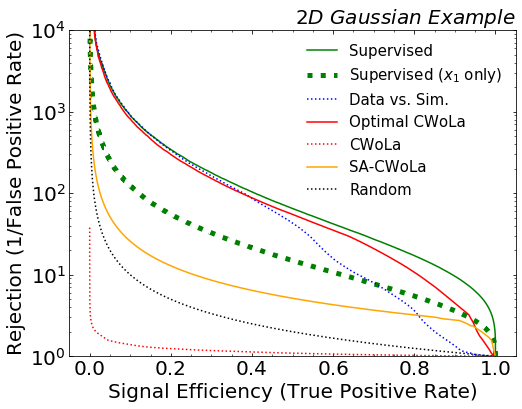

In [23]:
# Plot without banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med, label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

# plt.savefig('plots/toy_medians_100_epochs.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/toy_medians_100_epochs.pdf', bbox_inches='tight', padinches=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


Text(1.0, 1.0, '$2D$ $Gaussian$ $Example$')

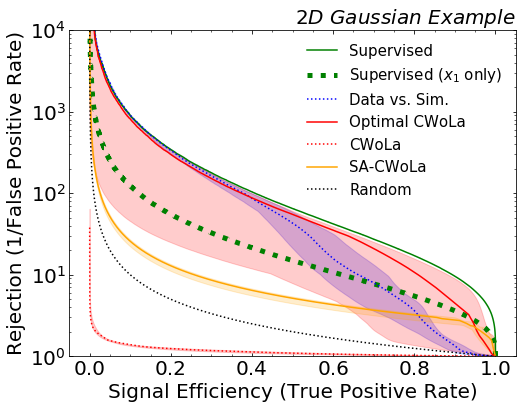

In [24]:
# Plot with banding

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

plt.plot(tpr_pts, dvsim_med,label="Data vs. Sim.",color="blue",ls=":")
plt.fill_between(tpr_pts, dvsim_max, dvsim_min, color='blue', alpha=0.2)

plt.plot(tpr_pts, ocwola_med,label="Optimal CWoLa",color="red")
plt.fill_between(tpr_pts, ocwola_max, ocwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, cwola_med,label="CWoLa",color="red",ls=":")
plt.fill_between(tpr_pts, cwola_max, cwola_min, color='red', alpha=0.2)

plt.plot(tpr_pts, sacwola_med,label="SA-CWoLa",color="orange")
plt.fill_between(tpr_pts, sacwola_max, sacwola_min, color='orange', alpha=0.2)

plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


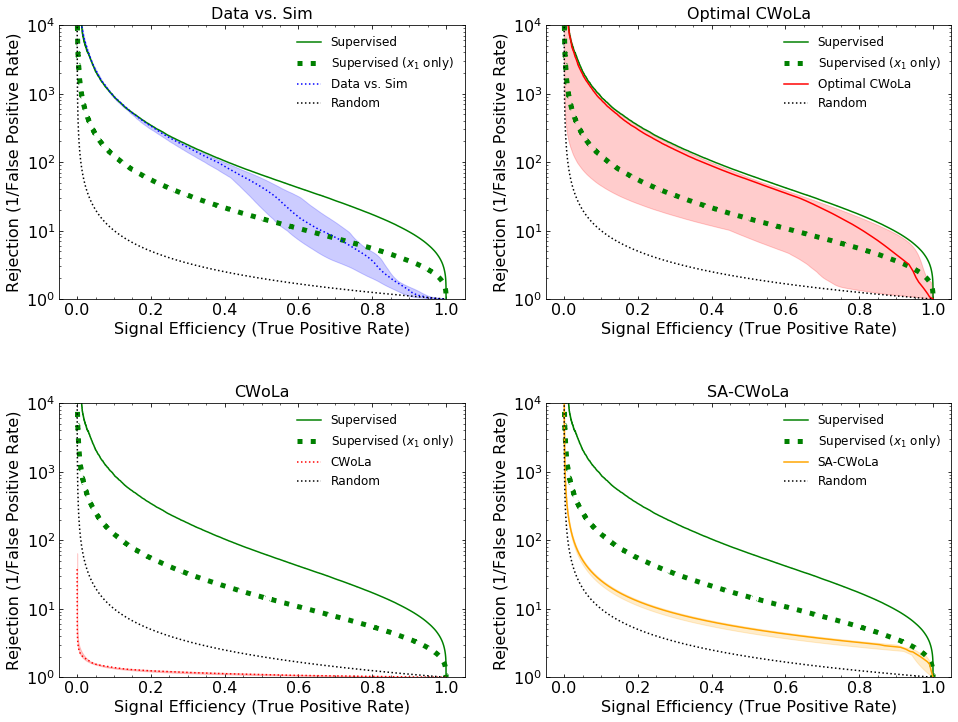

In [25]:
# Plot individual bands

bands = {'dvsim': (dvsim_max, dvsim_med, dvsim_min, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
         'ocwola': (ocwola_max, ocwola_med, ocwola_min, {'label':'Optimal CWoLa', 'color':'red'}),
         'cwola': (cwola_max, cwola_med, cwola_min, {'label':'CWoLa', 'color':'red', 'ls':':'}),
         'sacwola': (sacwola_max, sacwola_med, sacwola_min, {'label':'SA-CWoLa', 'color':'orange'})
        }

fig = plt.figure(figsize=(16, 12)) 
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.1, 1]) 

for i, key in enumerate(bands):
    row = 2 * math.floor(i / 2)
    col = i % 2
    
    ax0 = plt.subplot(gs[row, col])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.yscale("log")
    plt.ylim([1,1e4])
    
    line_max, line_med, line_min, opt = bands[key]

    plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
    plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

    plt.plot(tpr_pts, line_med, **opt)
    plt.fill_between(tpr_pts, line_max, line_min, color=opt['color'], alpha=0.2)

    plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

    plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
    plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
    plt.legend(frameon=False,fontsize=12,loc="upper right")
    
    plt.title(opt['label'], fontsize=16)

# plt.title("$2D$ $Gaussian$ $Example$",fontsize=20,loc="right")
# plt.savefig('plots/toy_min_max_bands_100_epochs.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/toy_min_max_bands_100_epochs.pdf', bbox_inches='tight', padinches=0)